In [13]:
!python student-help/conversion/yolov7/export.py --weights pole_model.pt  --grid --end2end --simplify \
--topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 640 640 --max-wh 640

Namespace(batch_size=1, conf_thres=0.35, device='cpu', dynamic=False, dynamic_batch=False, end2end=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.65, max_wh=640, simplify=True, topk_all=100, weights='pole_model.pt')
YOLOR 🚀 v0.1-115-g072f76c torch 1.12.1 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/Users/pds/Documents/interns/yolo-team-help/ONNX_inference_team12/.venv/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS

Starting TorchScript export with torch 1.12.1...
/Users/pds/Documents/interns/yolo-team-hel

In [14]:
# Inference for ONNX model
# Importing necessary libraries.
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple
import matplotlib.pyplot as plt

cuda = False
w = "pole_model.onnx"
# Loading image for testing.
img = cv2.imread("pole.jpg")

In [15]:
# Loading the ONNX inference session.
providers = (
    ["CUDAExecutionProvider", "CPUExecutionProvider"]
    if cuda
    else ["CPUExecutionProvider"]
)
session = ort.InferenceSession(w, providers=providers)


def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)


# Name of the classes according to class indices.
# Make sure all your classes are in this list in the right order!!
names = ["fibre-pole"]

# Creating random colors for bounding box visualization.
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

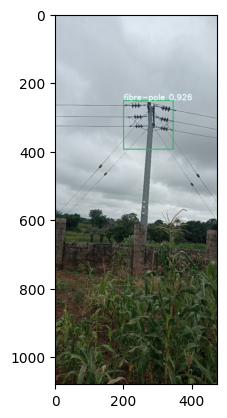

In [16]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Preprocessing the image for prediction.
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

# Getting onnx graph input and output names.
outname = [i.name for i in session.get_outputs()]
inname = [i.name for i in session.get_inputs()]
inp = {inname[0]: im}

# Running inference using session.
outputs = session.run(outname, inp)[0]


ori_images = [img.copy()]

# Visualizing bounding box prediction.
for i, (batch_id, x0, y0, x1, y1, cls_id, score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0, y0, x1, y1])
    box -= np.array(dwdh * 2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score), 3)
    name = names[cls_id]
    color = colors[name]
    name += " " + str(score)
    cv2.rectangle(image, box[:2], box[2:], color, 2)
    cv2.putText(
        image,
        name,
        (box[0], box[1] - 2),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.75,
        [225, 255, 255],
        thickness=2,
    )

plt.imshow(ori_images[0])